In [7]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4, data_home="./images")


In [8]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
print(target_names)
n_classes = target_names.shape[0]
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']
Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [9]:
# Split into a training set and a test set using a stratified k fold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#Convert to tensors 
X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

# Center data
mean = torch.mean(X_train, axis=0)
X_train -= mean
X_test -= mean


In [10]:
#Eigen-decomposition

U, S, V = torch.linalg.svd(X_train, full_matrices=False)

components = V[:n_components]
eigenfaces = torch.reshape(components, (n_components, h, w))

#project into PCA subspace
X_transformed = torch.matmul(X_train, components.T)
print(X_transformed.shape)
X_test_transformed = torch.matmul(X_test, components.T)
print(X_test_transformed.shape)

torch.Size([966, 150])
torch.Size([322, 150])


In [11]:
# Qualitative evaluation of the predictions using matplotlib
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
  """Helper function to plot a gallery of portraits"""
  plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
  plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
  for i in range(n_row * n_col):
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
    plt.title(titles[i], size=12)
    plt.xticks(())
    plt.yticks(())

In [12]:
def Performance(S, n_samples, n_components):
    explained_variance = (S ** 2) / (n_samples - 1)
    total_var = explained_variance.sum()
    explained_variance_ratio = explained_variance / total_var
    ratio_cumsum = torch.cumsum(explained_variance_ratio, dim = -1)
    eigenvalueCount = torch.arange(n_components)
    plt.plot(eigenvalueCount, ratio_cumsum[:n_components])
    plt.title('Compactness')
    plt.show()

In [13]:
def classify_faces(X_transformed, y_train, y_test, X_test_transformed, target_names):
    #transfer to numpy 
    X_transformed = X_transformed.numpy()
    y_test = y_test.numpy()
    y_train = y_train.numpy()
    X_test_transformed = X_test_transformed.numpy()

    #build random forest
    estimator = RandomForestClassifier(n_estimators=150, max_depth=15, max_features=150)
    estimator.fit(X_transformed, y_train) #expects X as [n_samples, n_features]

    predictions = estimator.predict(X_test_transformed)
    correct = predictions==y_test

    total_test = len(X_test_transformed)
    #print("Gnd Truth:", y_test)
    print("Total Testing", total_test)
    print("Predictions", predictions)
    print("Which Correct:",correct)
    print("Total Correct:",torch.sum(torch.tensor(correct)))
    print("Accuracy:",torch.sum(torch.tensor(correct))/total_test)
    print(classification_report(y_test, predictions, target_names=target_names))


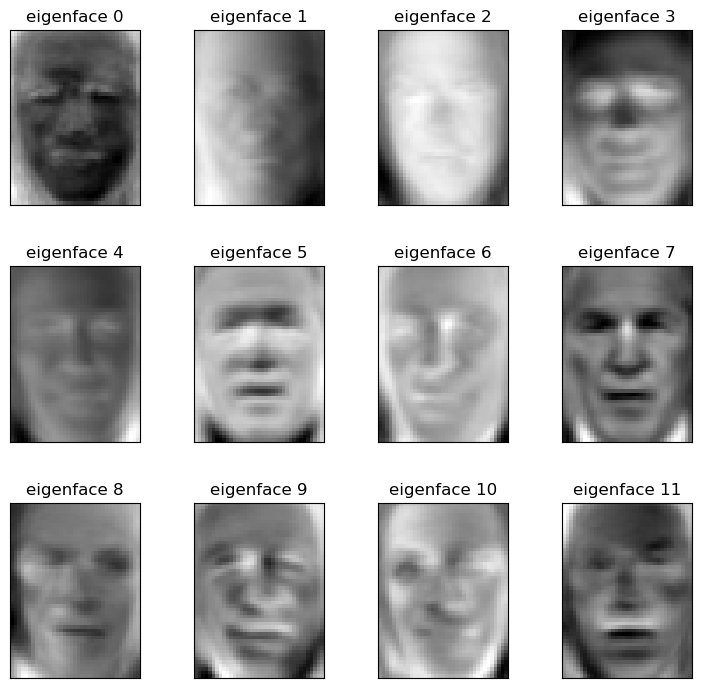

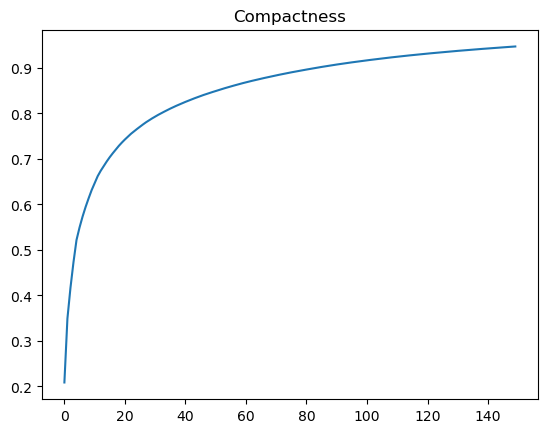

[ True  True  True  True  True  True False  True  True  True  True  True
  True False  True  True  True  True  True  True  True False  True False
 False  True False  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
 False  True  True  True False  True False  True  True  True False  True
  True  True False False  True  True False  True  True  True False False
  True  True  True  True False False False False False False False  True
  True  True  True  True  True False False  True  True False  True False
  True  True False  True  True False  True False  True  True  True  True
  True  True False  True False  True  True False False  True  True  True
  True  True  True False  True  True False  True  True False  True  True
 False False False  True  True  True False False False False False  True
  True False False  True False  True False False False  True  True  True
  True False False  True False  True  True  True  T

c:\Local\Miniconda\envs\Pytorch2\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Local\Miniconda\envs\Pytorch2\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Local\Miniconda\envs\Pytorch2\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

Performance(S, n_samples, n_components)
classify_faces(X_transformed, y_train, y_test, X_test_transformed, target_names)
